# [DOC](https://docs.fast.ai/tutorial.siamese.html)

In [55]:
dependencies = [
    "timm"
]

!pip install -U {" ".join(dependencies)}

from fastai.imports import *

In [11]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)
files = get_image_files(path/"images")
files[0]

Path('/Users/cactus/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_167.jpg')

# A New Data Block

### Defining A New Type For Our Model Input

<Axes: title={'center': 'True'}>

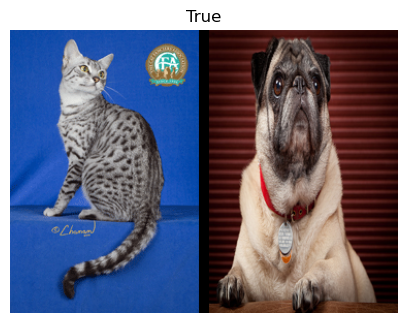

In [12]:
# First let's create a type for a pair of image with a label
# img1, img2, True/False

class SiameseImage(fastuple):
    def show(self, ctx=None, **kwargs):
        if len(self) > 2:
            img1,img2,similarity = self
        else:
            img1,img2 = self
            similarity = 'Undetermined' 

        # support for Tensor and PILImage
        if not isinstance(img1, Tensor):
            if img2.size != img1.size: img2 = img2.resize(img1.size)
            t1,t2 = tensor(img1),tensor(img2)
            t1,t2 = t1.permute(2,0,1),t2.permute(2,0,1)
        else: t1,t2 = img1,img2
        

        # the important part
        # - we stich both images as one tensor
        # - we create a black line
        # - note that the label is not part of the tensor 
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), 
                           title=similarity, ctx=ctx, **kwargs)

# Note that we used the fastai type PILImage instead of a PIL.Image
img1 = PILImage.create(files[0])
img2 = PILImage.create(files[1])
s1 = SiameseImage(img1, img2, True)
s1.show()

<Axes: title={'center': 'True'}>

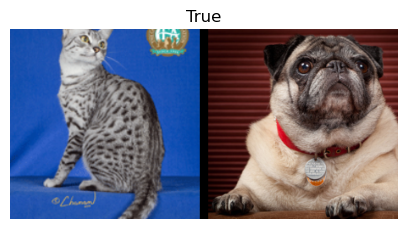

In [13]:
# transform works on tuple
# it applies to s1.img1 and s1.img2, but not to s1.similarity because it's not supported
s2 = Resize(224)(s1)
s2 = ToTensor()(s2)
s2.show()

### Creating a Transform That Turn Files Into Our New Type

In [14]:
# we need a function to determine the label of our image
def label_func(fname):
    return re.match(r'^(.*)_\d+.jpg$', fname.name).groups()[0]

label_func(files[0])

'Egyptian_Mau'

__Siamese = same race/class__

In [15]:
# Let's create a Transform that help us go from filenames to SiameseImages
class SiameseTransform(Transform):
    def __init__(self, files, label_func, splits):
        self.labels = list(set(files.map(label_func)))
        self.label_func = label_func
        self.splbl2files = [{l: [f for f in files[splits[i]] if label_func(f) == l] for l in self.labels}
                          for i in range(2)]
        self.valid = {f: self._draw(f,1) for f in files[splits[1]]}
        
    def encodes(self, f):
        f2,same = self.valid.get(f, self._draw(f,0))
        img1,img2 = PILImage.create(f),PILImage.create(f2)
        return SiameseImage(img1, img2, same)
    
    def _draw(self, f, split=0):
        same = random.random() < 0.5
        cls = self.label_func(f)        
        if not same: cls = random.choice(L(l for l in self.labels if l != cls)) 
        return random.choice(self.splbl2files[split][cls]),same


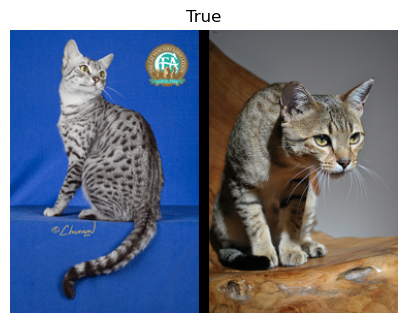

In [16]:
splits = RandomSplitter()(files)
tfm = SiameseTransform(files, label_func, splits)
tfm(files[0]).show();

In [17]:
# check that valid and train set are indeed separate
valids = [v[0] for k,v in tfm.valid.items()]      
assert not [v for v in valids if v in files[splits[0]]]

### From Transform To TfmdLists

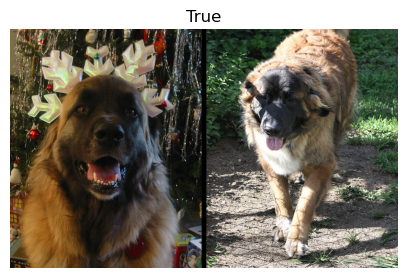

In [18]:
# Let's put the Transform into a TfmdLists

tls = TfmdLists(files, tfm, splits=splits)
show_at(tls.train, 0);

# Training set got a random label, regardless of if they are Siamese or not

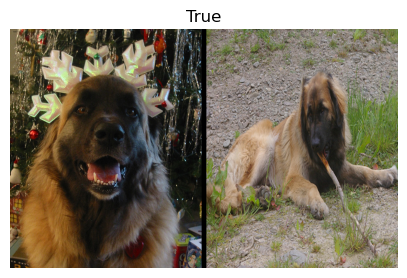

In [19]:
# Let's check that validation set correctly label if they are Siamese
show_at(tls.train, 0);
# it should return True if they are Siamese (same race)

### From TfmdLists To DataLoaders

In [20]:
dls = tls.dataloaders(after_item=[Resize(224), ToTensor], 
                      after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

Instead of having a batch, we got a siamese image?

In [21]:
b = dls.one_batch()
type(b)

__main__.SiameseImage

In [22]:
dls._types

{__main__.SiameseImage: [fastai.torch_core.TensorImage,
  fastai.torch_core.TensorImage,
  torch.Tensor]}

### Fixing show_batch()

We are still missing something to make dls.show_batch() work

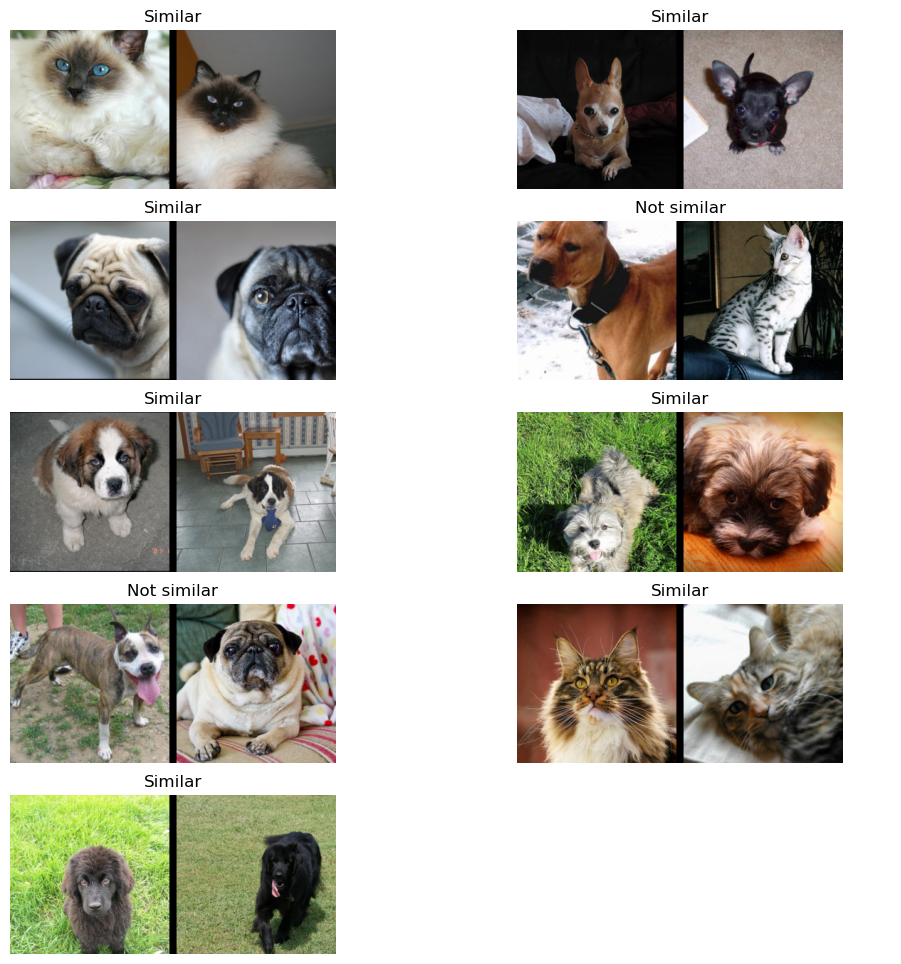

In [23]:
# we need to create a new version of show_batch
# that knows how to handle input that is of type SiameseImage

@typedispatch
def show_batch(x:SiameseImage, y, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): SiameseImage(x[0][i], x[1][i], ['Not similar','Similar'][x[2][i].item()]).show(ctx=ctx)

dls.show_batch()


We will see later how to make it more smooth when a batch doesn't have a show method (which is the case most of the time, only the input and target of the batch have those show methods)

In that case, the arguments `y` and `samples` are useful.

Here, everything is in `x`, because since the batch knows ho to show itself as a whole, it is sent as a whole.

### Writting Your Custom DataBlock

What we did before is perfectly fine and enough to go work with a model.
However let's see how we can create a DataBlock so that we can handle similar cases where we have a custom inputs shape such the SiameseImage tuple.

In [24]:
# instead of calling it Siamese, let's call it ImageTuple
class ImageTuple(fastuple):
    @classmethod
    def create(cls, fns): return cls(tuple(PILImage.create(f) for f in fns))
    
    def show(self, ctx=None, **kwargs): 
        t1,t2 = self
        if not isinstance(t1, Tensor) or not isinstance(t2, Tensor) or t1.shape != t2.shape: return ctx
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), ctx=ctx, **kwargs)

Since we used fastuple, any transform applied to that type will be applied
to any items within that ImageTuple type

In [25]:
img = ImageTuple.create((files[0], files[1]))
tst = ToTensor()(img)
type(tst[0]),type(tst[1])

(fastai.torch_core.TensorImage, fastai.torch_core.TensorImage)

In the show method, we did not bother with non-tensor elements this time (we could copy and paste the same code as before). Showing assumes we have a resize transform and that we convert the images to tensors in our procesing pipeline:

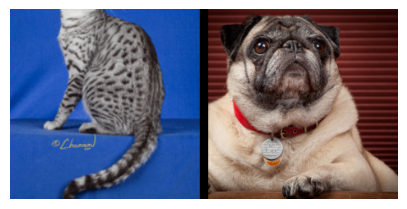

In [26]:
img1 = Resize(224)(img)
tst = ToTensor()(img1)
tst.show();

In [27]:
# HERES OUR DATABLOCK!
def ImageTupleBlock():
    return TransformBlock(type_tfms=ImageTuple.create, batch_tfms=IntToFloatTensor)

In [28]:
# labels
labels = list(set(files.map(label_func)))
L(labels)

(#37) ['american_pit_bull_terrier','miniature_pinscher','saint_bernard','english_setter','samoyed','Persian','leonberger','pug','Egyptian_Mau','yorkshire_terrier'...]

In [29]:
# split
splits_files = [files[splits[i]] for i in range(2)]
splits_sets = mapped(set, splits_files)

def get_split(f):
    for i,s in enumerate(splits_sets):
        if f in s: return i
    raise ValueError(f'File {f} is not presented in any split.')

splbl2files = [{l: [f for f in s if label_func(f) == l] for l in labels} for s in splits_sets]

def splitter(items): 
    def get_split_files(i): return [j for j,(f1,f2,same) in enumerate(items) if get_split(f1)==i]
    return get_split_files(0),get_split_files(1)

In [30]:
# defining how to get items
def draw_other(f):
    same = random.random() < 0.5
    cls = label_func(f)
    split = get_split(f)
    if not same: cls = random.choice(L(l for l in labels if l != cls)) 
    return random.choice(splbl2files[split][cls]),same

def get_tuples(files): return [[f, *draw_other(f)] for f in files]

In [31]:
def get_x(t): return t[:2]
def get_y(t): return t[2]

In [32]:
# The DataBlock
dblock = DataBlock(
    blocks=(ImageTupleBlock, CategoryBlock),
    get_items=get_tuples,
    get_x=get_x, get_y=get_y,
    splitter=splitter,
    item_tfms=Resize(224),
    batch_tfms=[Normalize.from_stats(*imagenet_stats)]
)

dls = dblock.dataloaders(files)

In [33]:
b = dls.one_batch()
explode_types(b)

{tuple: [{__main__.ImageTuple: [fastai.torch_core.TensorImage,
    fastai.torch_core.TensorImage]},
  fastai.torch_core.TensorCategory]}

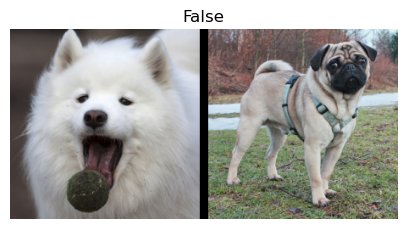

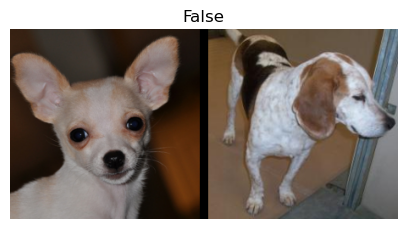

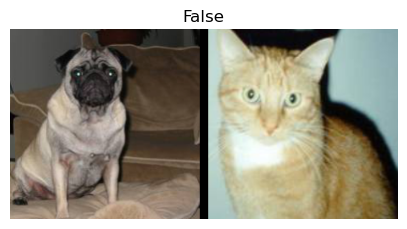

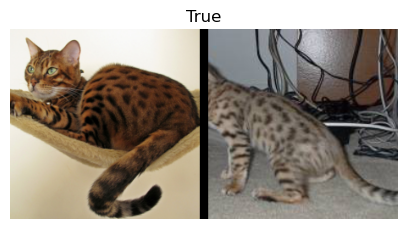

In [34]:
# show_batch now works out of the box because one_batch returns a tuple!
dls.show_batch(max_n=4)

Let's customize a bit the grid

Here the whole batch is just a tuple, so doesn’t have a show method. The fastai library will dispatch on the first part of the tuple (`x`) and second part of the tuple (`y`), the actual samples being in the `samples` variable.

Here we only dispatch on the `x` (which means this method will be used for xs that are `ImageTuple` and any ys), but we could have custom behaviors depending on the targets.

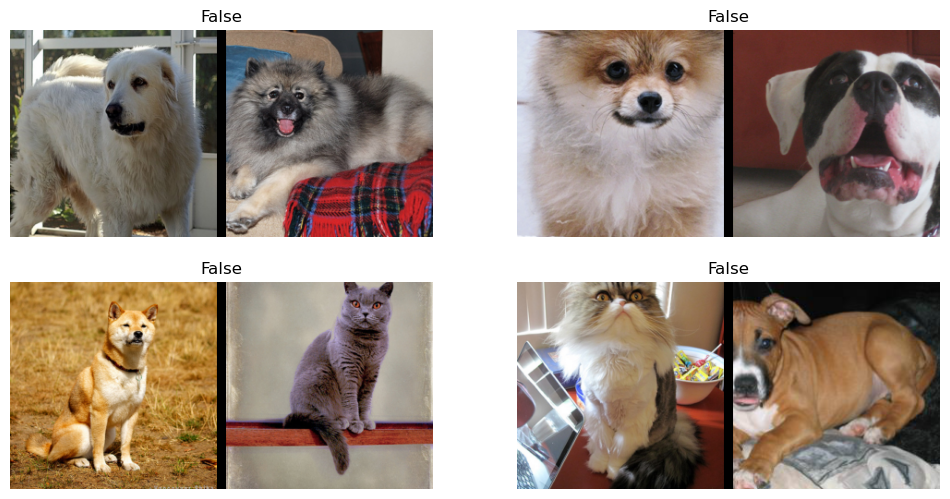

In [35]:
@typedispatch
def show_batch(x:ImageTuple, y, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(len(samples), max_n), nrows=nrows, ncols=ncols, figsize=figsize)
    ctxs = show_batch[object](x, y, samples, ctxs=ctxs, max_n=max_n, **kwargs)
    return ctxs

dls.show_batch(max_n=4)